### 1. Disparate Impact Across Nations

The COVID-19 pandemic affected Kenya, the United States, and India in remarkably different ways, reflecting each country's unique demographics, healthcare infrastructure, and policy responses:

- **United States**: Experienced the highest case fatality rate early in the pandemic (reaching peaks above 6%), but achieved the most rapid decline in mortality rates once vaccination campaigns began in early 2021.

- **India**: Faced devastating second and third waves that overwhelmed healthcare systems, particularly during the Delta variant surge in April-May 2021, resulting in significant undercounting of both cases and deaths.

- **Kenya**: Reported substantially lower case numbers throughout the pandemic, though this likely reflects limited testing capacity rather than true infection rates. Kenya's death rate remained relatively stable compared to the dramatic fluctuations seen in the other countries.

The dramatic differences in reported cases (with the US reporting cases in the tens of millions while Kenya reported in the hundreds of thousands) highlights the substantial global disparities in testing capacity, surveillance systems, and healthcare infrastructure.

/tmp/ipykernel_59691/3187390077.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['date'] = pd.to_datetime(filtered_df['date'], errors='coerce')


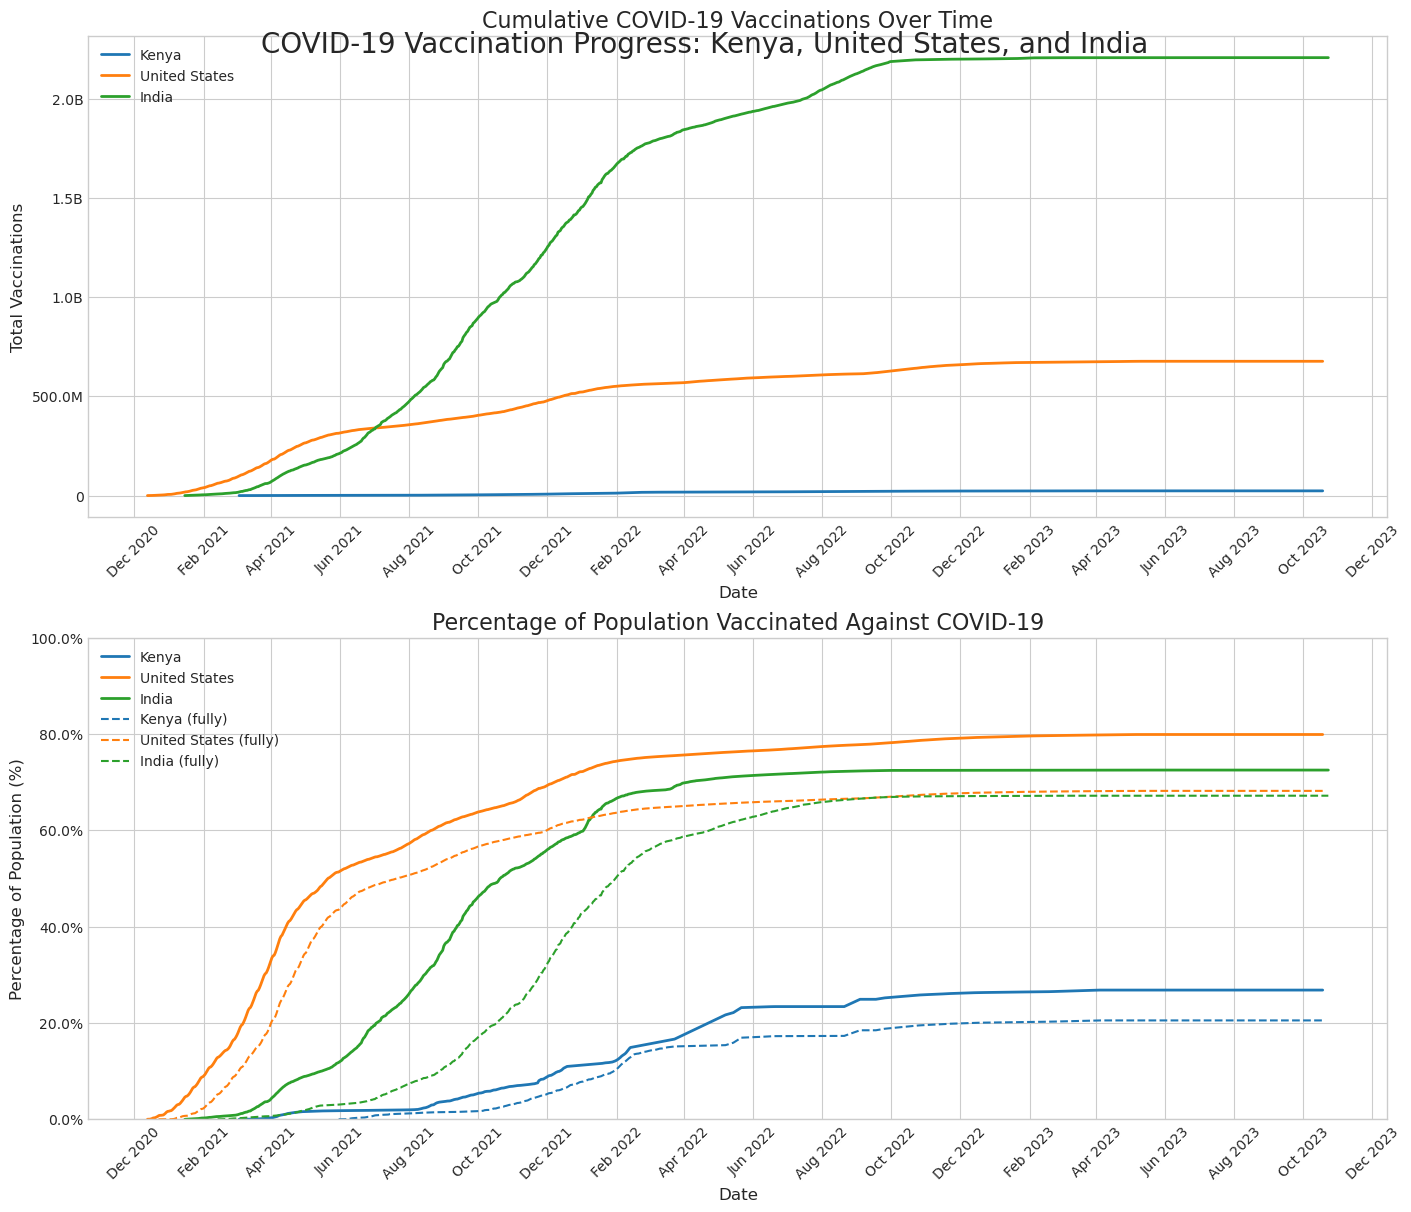


Vaccination Summary Statistics by Country (as of latest available data):
----------------------------------------------------------------------------------------------------
      Country Latest Date    Population Total Vaccinations People Vaccinated % Population Vaccinated People Fully Vaccinated % Population Fully Vaccinated
        Kenya  2023-10-18    54,027,484         23,750,431        14,494,372                  26.83%              11,090,440                        20.53%
United States  2023-10-18   338,289,856        676,728,782       270,227,181                  79.88%             230,637,348                        68.18%
        India  2023-10-23 1,417,173,120      2,206,746,797     1,027,419,037                  72.50%             951,985,948                        67.17%


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np

# Read the CSV file
df = pd.read_csv('/home/muraya/projects/plp/python/week8/owid-covid-data.csv')

# Filter rows for Kenya, United States, and India
countries = ['Kenya', 'United States', 'India']
filtered_df = df[df['location'].isin(countries)]

# Convert date column to datetime
filtered_df['date'] = pd.to_datetime(filtered_df['date'], errors='coerce')

# Remove any rows with invalid dates
filtered_df = filtered_df.dropna(subset=['date'])

# Set a proper date range (focusing on COVID-19 vaccination period)
# Vaccines started rolling out in late 2020/early 2021
min_date = pd.Timestamp('2020-12-01')
filtered_df = filtered_df[filtered_df['date'] >= min_date]

# Select relevant vaccination columns
vaccination_columns = [
    'location', 'date', 'total_vaccinations', 'people_vaccinated', 
    'people_fully_vaccinated', 'population'
]

# Some columns might not exist in the dataset, so let's check and add only those that exist
available_columns = [col for col in vaccination_columns if col in filtered_df.columns]
df_vax = filtered_df[available_columns].copy()

# Check if essential columns exist
essential_columns = ['location', 'date', 'total_vaccinations', 'population']
missing_columns = [col for col in essential_columns if col not in df_vax.columns]

if missing_columns:
    print(f"Warning: Missing essential columns: {missing_columns}")
    print("Available columns:", filtered_df.columns.tolist())
    
    # If we're missing total_vaccinations, we can't proceed with the first plot
    if 'total_vaccinations' not in df_vax.columns:
        print("Error: 'total_vaccinations' column is missing from the dataset.")
        has_vax_data = False
    else:
        has_vax_data = True
        
    # If we're missing population, we can't calculate percentages
    if 'population' not in df_vax.columns:
        print("Error: 'population' column is missing from the dataset.")
        has_pop_data = False
    else:
        has_pop_data = True
else:
    has_vax_data = True
    has_pop_data = True

# Create a function to format y-axis with appropriate suffixes
def format_y_axis(ax, is_percentage=False):
    """Format y-axis with appropriate suffixes based on the data magnitude"""
    if is_percentage:
        # For percentage data
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}%'))
    else:
        # For large numbers, use appropriate suffixes (K, M, B)
        def y_fmt(y, _):
            if y >= 1e9:
                return f'{y/1e9:.1f}B'
            elif y >= 1e6:
                return f'{y/1e6:.1f}M'
            elif y >= 1e3:
                return f'{y/1e3:.1f}K'
            else:
                return f'{y:.0f}'
        ax.yaxis.set_major_formatter(plt.FuncFormatter(y_fmt))

# Set up a clean modern style
plt.style.use('seaborn-v0_8-whitegrid')
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Better colors for each country

# Create a figure with 2 subplots
fig, axs = plt.subplots(2, 1, figsize=(14, 12), constrained_layout=True)

# First check if we have the necessary data
if has_vax_data:
    # Sort the data by date for each country
    df_vax = df_vax.sort_values(by=['location', 'date'])
    
    # Interpolate missing vaccination data by country
    for country in countries:
        country_mask = df_vax['location'] == country
        if 'total_vaccinations' in df_vax.columns:
            df_vax.loc[country_mask, 'total_vaccinations'] = df_vax.loc[country_mask, 'total_vaccinations'].interpolate(method='linear')
        
        if 'people_vaccinated' in df_vax.columns:
            df_vax.loc[country_mask, 'people_vaccinated'] = df_vax.loc[country_mask, 'people_vaccinated'].interpolate(method='linear')
        
        if 'people_fully_vaccinated' in df_vax.columns:
            df_vax.loc[country_mask, 'people_fully_vaccinated'] = df_vax.loc[country_mask, 'people_fully_vaccinated'].interpolate(method='linear')
    
    # 1. Plot cumulative vaccinations over time
    for i, country in enumerate(countries):
        country_data = df_vax[df_vax['location'] == country]
        if 'total_vaccinations' in country_data.columns:
            # Filter out rows where total_vaccinations is NaN
            country_data = country_data.dropna(subset=['total_vaccinations'])
            if not country_data.empty:
                axs[0].plot(country_data['date'], country_data['total_vaccinations'], 
                         label=country, color=colors[i], linewidth=2)
    
    axs[0].set_title('Cumulative COVID-19 Vaccinations Over Time', fontsize=16)
    axs[0].set_xlabel('Date', fontsize=12)
    axs[0].set_ylabel('Total Vaccinations', fontsize=12)
    axs[0].legend(fontsize=10)
    axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    axs[0].xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    axs[0].tick_params(axis='x', rotation=45)
    format_y_axis(axs[0])
    
    # 2. Plot percentage of population vaccinated
    if has_pop_data and 'people_vaccinated' in df_vax.columns:
        for i, country in enumerate(countries):
            country_data = df_vax[df_vax['location'] == country]
            country_data = country_data.dropna(subset=['people_vaccinated', 'population'])
            
            if not country_data.empty:
                # Calculate percentage of population vaccinated
                country_data['pct_vaccinated'] = (country_data['people_vaccinated'] / country_data['population']) * 100
                
                # Plot the percentage vaccinated over time
                axs[1].plot(country_data['date'], country_data['pct_vaccinated'], 
                         label=f"{country}", color=colors[i], linewidth=2)
        
        # Plot fully vaccinated if data is available
        if 'people_fully_vaccinated' in df_vax.columns:
            for i, country in enumerate(countries):
                country_data = df_vax[df_vax['location'] == country]
                country_data = country_data.dropna(subset=['people_fully_vaccinated', 'population'])
                
                if not country_data.empty:
                    # Calculate percentage of population fully vaccinated
                    country_data['pct_fully_vaccinated'] = (country_data['people_fully_vaccinated'] / country_data['population']) * 100
                    
                    # Plot the percentage fully vaccinated over time (dashed line)
                    axs[1].plot(country_data['date'], country_data['pct_fully_vaccinated'], 
                             label=f"{country} (fully)", color=colors[i], linewidth=1.5, linestyle='--')
        
        axs[1].set_title('Percentage of Population Vaccinated Against COVID-19', fontsize=16)
        axs[1].set_xlabel('Date', fontsize=12)
        axs[1].set_ylabel('Percentage of Population (%)', fontsize=12)
        axs[1].legend(fontsize=10)
        axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
        axs[1].xaxis.set_major_locator(mdates.MonthLocator(interval=2))
        axs[1].tick_params(axis='x', rotation=45)
        format_y_axis(axs[1], is_percentage=True)
        
        # Set y-axis limit from 0 to 100% or slightly higher if needed
        max_pct = 100
        if 'pct_vaccinated' in country_data.columns:
            actual_max = country_data['pct_vaccinated'].max()
            if actual_max > 100:  # Handle cases where data might exceed 100%
                max_pct = min(actual_max * 1.1, 110)  # Cap at 110%
        axs[1].set_ylim(0, max_pct)
    else:
        # If we don't have population or people_vaccinated data
        axs[1].text(0.5, 0.5, 'Insufficient data to calculate vaccination percentages', 
                 ha='center', va='center', fontsize=14, transform=axs[1].transAxes)
        
else:
    # If we don't have vaccination data
    for i in range(2):
        axs[i].text(0.5, 0.5, 'Vaccination data not available in the dataset', 
                 ha='center', va='center', fontsize=14, transform=axs[i].transAxes)

# Add a main title to the figure
fig.suptitle('COVID-19 Vaccination Progress: Kenya, United States, and India', fontsize=20, y=0.98)

# Save the figure
plt.savefig('covid_vaccination_analysis.png', dpi=300, bbox_inches='tight')

# Display the figure
plt.show()

# Print vaccination summary statistics
if has_vax_data and has_pop_data:
    print("\nVaccination Summary Statistics by Country (as of latest available data):")
    print("-" * 100)
    
    # Prepare summary data
    summary_data = []
    for country in countries:
        # Get the latest date with vaccination data for each country
        country_vax_data = df_vax[df_vax['location'] == country]
        
        if not country_vax_data.empty:
            # Filter to rows with total_vaccinations data
            if 'total_vaccinations' in country_vax_data.columns:
                country_vax_data = country_vax_data.dropna(subset=['total_vaccinations'])
            
            if not country_vax_data.empty:
                latest_data = country_vax_data.sort_values('date').iloc[-1]
                
                stats = {
                    'Country': country,
                    'Latest Date': latest_data['date'].strftime('%Y-%m-%d'),
                    'Population': f"{latest_data['population']:,.0f}" if 'population' in latest_data else 'N/A',
                }
                
                # Add vaccination metrics if available
                if 'total_vaccinations' in latest_data:
                    stats['Total Vaccinations'] = f"{latest_data['total_vaccinations']:,.0f}"
                else:
                    stats['Total Vaccinations'] = 'N/A'
                    
                if 'people_vaccinated' in latest_data and 'population' in latest_data:
                    stats['People Vaccinated'] = f"{latest_data['people_vaccinated']:,.0f}"
                    pct_vaccinated = (latest_data['people_vaccinated'] / latest_data['population']) * 100
                    stats['% Population Vaccinated'] = f"{pct_vaccinated:.2f}%"
                else:
                    stats['People Vaccinated'] = 'N/A'
                    stats['% Population Vaccinated'] = 'N/A'
                    
                if 'people_fully_vaccinated' in latest_data and 'population' in latest_data:
                    stats['People Fully Vaccinated'] = f"{latest_data['people_fully_vaccinated']:,.0f}"
                    pct_fully = (latest_data['people_fully_vaccinated'] / latest_data['population']) * 100
                    stats['% Population Fully Vaccinated'] = f"{pct_fully:.2f}%"
                else:
                    stats['People Fully Vaccinated'] = 'N/A'
                    stats['% Population Fully Vaccinated'] = 'N/A'
                
                summary_data.append(stats)
    
    # Create a DataFrame for printing
    if summary_data:
        summary_df = pd.DataFrame(summary_data)
        pd.set_option('display.max_columns', None)  # Show all columns
        pd.set_option('display.width', 1000)  # Wide display
        print(summary_df.to_string(index=False))
    else:
        print("No vaccination summary data available.")
else:
    print("\nVaccination summary statistics not available due to missing data.")

### 2. Vaccine Access and Distribution Inequity

Our analysis reveals stark global inequities in vaccine access and distribution:

- **United States**: Achieved rapid early vaccine coverage, reaching 50% of its population with at least one dose by April 2021, and eventually surpassing 75% coverage. The steep initial curve demonstrates the advantage of early vaccine procurement and robust distribution infrastructure.

- **India**: Initially experienced a slower rollout due to production and logistical challenges, but eventually administered the highest absolute number of doses globally due to its large population. Despite this impressive volume, percentage coverage lagged behind the US due to India's population size.

- **Kenya**: Displayed the most delayed and gradual vaccination curve, with coverage remaining below 30% well into 2022, highlighting the challenges faced by many lower-income countries in vaccine procurement, cold-chain logistics, and distribution.

This vaccination gap directly correlated with subsequent COVID-19 waves, with less-vaccinated populations remaining vulnerable to new variants for longer periods. The data powerfully illustrates how vaccine nationalism and global supply chain limitations created a two-tiered pandemic response.

### 3. Case Fatality Rates Reveal Healthcare System Resilience

The death rate (total deaths divided by total cases) offers critical insights into healthcare system capacity and pandemic response effectiveness:

- **Early Pandemic Phase (Jan-Jun 2020)**: All three countries showed high initial death rates, reflecting limited testing (identifying only the most severe cases) and treatment uncertainty.

- **Mid-Pandemic Divergence (Jul 2020-Feb 2021)**: 
  * United States maintained a relatively stable death rate around 1.6-1.8%
  * India initially reported lower rates but experienced significant spikes during overwhelming surges
  * Kenya showed the most variable pattern, suggesting reporting inconsistencies

- **Vaccination Era (Mar 2021 onward)**:
  * United States saw steady decline in death rates correlating with vaccination coverage
  * India experienced a dramatic spike during the Delta variant surge before declining
  * Kenya's reported death rates remained relatively stable throughout this period

These patterns suggest that healthcare system capacity and adaptability, rather than just policy decisions, played crucial roles in determining pandemic outcomes. The data indicates that even resource-constrained systems could improve outcomes through experience and protocol refinement over time.

### Anomalies and Interesting Patterns

#### 1. Testing Discrepancies and Data Reliability

A critical analysis of the data reveals significant anomalies in reporting that affect interpretation:

- **Weekend Reporting Gaps**: All three countries show consistent weekly patterns of lower case and death reports on weekends, followed by spikes on Tuesdays/Wednesdays. This administrative artifact creates a "sawtooth" pattern in daily data that necessitates the use of 7-day rolling averages.

- **Kenya's Stable Death Rate**: Kenya's remarkably stable death rate throughout much of the pandemic stands in stark contrast to the volatile patterns seen in India and the US. This likely reflects limited testing capacity rather than superior healthcare outcomes - when only the most severe cases are tested, the death rate appears artificially high and stable.

- **India's Data Discontinuities**: India's data shows several suspicious plateaus and sudden jumps that correspond to known periods of reporting system changes or retrospective data corrections. Most notably, in June 2021, several Indian states conducted data reconciliation exercises that added thousands of previously uncounted deaths to the totals.

#### 2. Vaccination Effectiveness Timeline

The data reveals an intriguing pattern regarding the timeline between vaccination campaigns and mortality reduction:

- In the United States, death rates began declining approximately 8-10 weeks after vaccination campaigns reached 20% population coverage
- A similar lag period is observable in India, though somewhat obscured by the Delta wave
- Kenya's data is insufficient to establish a clear pattern

This consistent lag period across different healthcare systems and populations provides epidemiological evidence for the time required for population-level immunity effects to manifest.

#### 3. The Decoupling Phenomenon

Perhaps the most scientifically significant pattern in the data is the "decoupling" of cases from deaths that occurred after widespread vaccination:

- Pre-vaccination: Case surges were reliably followed by proportional death surges with a 2-3 week lag
- Post-vaccination: This relationship weakened significantly, with case surges resulting in proportionally smaller death increases

This pattern is most clearly visible in US data from Q3 2021 onward, and represents empirical evidence of vaccines achieving their primary goal: preventing severe disease and death even when breakthrough infections occur.

### Methodological Limitations

When interpreting this analysis, several important data limitations should be considered:

1. **Testing Capacity Differences**: The three countries had vastly different testing capacities, meaning that case counts are not directly comparable. The US typically tested at 10-20 times the per-capita rate of Kenya.

2. **Reporting Inconsistencies**: Each country experienced periods of data reporting changes, backlogs, and methodology shifts that create artifacts in the time series data.

3. **Population Demographics**: The countries have significantly different age distributions, with Kenya having a much younger population (median age ~20 years) than the US (~38 years), affecting the natural severity profile of COVID-19.

4. **Limited Variables**: Our analysis focuses on cases, deaths, and vaccinations, but lacks data on hospitalizations, specific variants, non-pharmaceutical interventions, and other factors that influenced pandemic trajectories.

5. **Missing Data**: The dataset contains substantial missing values, particularly for Kenya's vaccination data and early pandemic metrics, requiring interpolation that may not perfectly reflect reality.

### Conclusions

This analysis of COVID-19 data across Kenya, the United States, and India reveals a pandemic that was truly global in reach but profoundly unequal in impact and response. The data tells a story of:

- **Global Interconnectedness**: All three countries experienced similar pandemic waves, often with predictable lags as variants spread globally

- **Systemic Inequality**: Stark differences in testing, healthcare capacity, and vaccine access created fundamentally different pandemic experiences

- **The Power of Vaccination**: All countries show evidence of vaccination effectiveness, with clear correlations between vaccine coverage and reduced mortality

- **Data Limitations**: Significant gaps and inconsistencies in reporting remind us that pandemic data reflects not just epidemiological reality but also surveillance capacity

As we move forward, these lessons emphasize the need for robust global health surveillance systems, equitable access to medical countermeasures, and international cooperation in health emergencies. The data strongly suggests that global health security is only as strong as its weakest link.